In [1]:
#imports
import yaml
import warnings

import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score,roc_auc_score

from callables import prepare_dataset
from callables import process_dataset
from callables import model_train
from callables import plot_roc_curve, plot_confusion_matrix, plot_feature_importnaces, find_max_fscore 

warnings.filterwarnings('ignore')

In [2]:
#params
with open("params.yml", 'r') as file:
    params = yaml.safe_load(file)

root_path = params['root_path']
filepath_input = params['filepath_input']
model_name = params['model_name']

shift = params['shift']
anomaly_crtiretion = params['anomaly_crtiretion']
cb_params = params['cb_params']

In [3]:
#callables
df = prepare_dataset(root_path + filepath_input)
df_event, df_period, df_model = process_dataset(df, shift, anomaly_crtiretion)

In [4]:
#split
train, test = train_test_split(df_model, test_size = 0.2, random_state = 42, shuffle = False)

x_train = train.drop('target', axis = 1)
y_train = train.target.astype(int)

x_test = test.drop('target', axis = 1)
y_test = test.target.astype(int)

#fit best model
model = CatBoostClassifier(**cb_params)
model.fit(x_train, y_train)

# predict train probabilities
y_train_pred_proba = model.predict_proba(x_train)
y_train_pred_proba = y_train_pred_proba[:, 1]

# predict test probabilities
y_test_pred_proba = model.predict_proba(x_test)
y_test_pred_proba = y_test_pred_proba[:, 1]

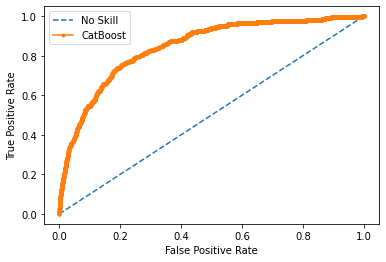

In [5]:
# plot roc curve
plot_roc_curve(y_test, y_test_pred_proba)

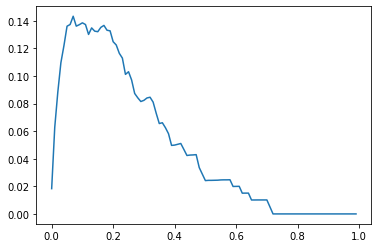

In [6]:
#plot_find_max_fscore
opt_cutoff = find_max_fscore(y_test, y_test_pred_proba)

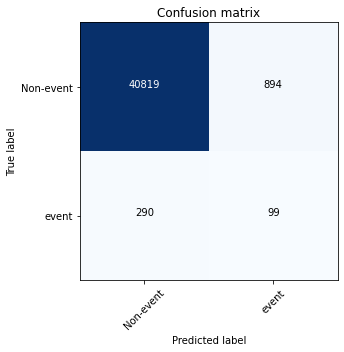

In [7]:
#plot_confusion_matrix
plot_confusion_matrix(y_test, y_test_pred_proba, opt_cutoff)

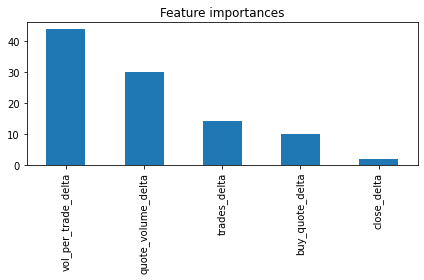

In [8]:
#plot_feature_importances
plot_feature_importnaces(model,x_train)

In [9]:
#calculate metrics
gini_train = round(100 * (2 * roc_auc_score(y_train, y_train_pred_proba) - 1),2)
gini_test  = round(100 * (2 * roc_auc_score(y_test, y_test_pred_proba) - 1),2)
f_score_train = round(100*f1_score(y_train, (y_train_pred_proba > opt_cutoff), pos_label=1, average='binary'),2)
f_score_test  = round(100*f1_score(y_test , (y_test_pred_proba  > opt_cutoff), pos_label=1, average='binary'),2)

metrics_df = pd.DataFrame({'gini_train' : [gini_train],
                           'gini_test':[gini_test],
                           'f_score_train':[f_score_train],
                           'f_score_test':[f_score_test]})

display(metrics_df)

,gini_train,gini_test,f_score_train,f_score_test
0,85.09,69.24,32.84,14.33


In [11]:
# model.save_model(root_path + model_name)